## EE 443 Final Project: Training Documentation 
#### Name: Jonathan Wong

## ---- Download Data ----
First, download the training data onto the local colab machine.

Then, restart runtime before continuing.

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import cv2, os, json
import argparse 
import shlex

def parse_args(input):
    parser = argparse.ArgumentParser(description="Train FGVC Network")

    parser.add_argument(
        "--input_path",
        help="input train/test splitting files",
        required=True,
        type=str,
    )
    parser.add_argument(
        "--cls_names_path",
        help="path for class name file",
        type=str,
        required=True
    )
    parser.add_argument(
        "--output_path",
        help="save path for converted file",
        type=str,
        required=False,
        default="."
    )

    # Input stuff
    input_list = shlex.split(input) 
    args = parser.parse_args(input_list)

    return args

def read_and_decode(filename_queue):
    """Parses a single tf.Example into image and label tensors."""
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        features={
            "image": tf.FixedLenFeature([], tf.string),
            "label": tf.FixedLenFeature([], tf.int64),
        })
    image = tf.decode_raw(features["image"], tf.uint8)
    image.set_shape([3 * 32 * 32])
    label = tf.cast(features["label"], tf.int32)
    return image, label

def convert_from_tfrecords(data_root, dir_name, num_class, mode, output_path, json_file_prefix, cls_names):
    if mode == 'test':
        tfrecord_path = os.path.join(data_root, dir_name, 'eval.tfrecords')
    else:
        tfrecord_path = os.path.join(data_root, dir_name, 'train.tfrecords')
    filename_queue = tf.train.string_input_producer([tfrecord_path], shuffle=False, num_epochs=1)

    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)
    image, label = read_and_decode(filename_queue)

    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess = tf.Session()
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    annotations = []
    try:
        step = 0
        while not coord.should_stop():
            images, labels = sess.run([image, label])
            if int(labels) % 2 != 0:
                continue
            images = cv2.cvtColor(images.reshape(3, 32, 32).transpose(1, 2, 0), cv2.COLOR_RGB2BGR)
            im_path = os.path.join(output_path, json_file_prefix, 'images', cls_names[int(labels)])
            if not os.path.exists(im_path):
                os.makedirs(im_path)
            save_path = os.path.join(im_path, '{}_{}.jpg'.format(mode, step))
            cv2.imwrite(save_path, images)
            annotations.append(
                {'fpath': save_path, 'image_id': step, 'category_id': int(labels), 'category': cls_names[int(labels)]})
            step += 1
    except tf.errors.OutOfRangeError:
        print('done')
    finally:
        coord.request_stop()

    with open(os.path.join(output_path, json_file_prefix, json_file_prefix + '_{}.json'.format(mode)), 'w') as f:
        json.dump({'annotations': annotations, 'num_classes': num_class}, f)

    print('Json has been saved to',
          os.path.join(output_path, json_file_prefix, json_file_prefix + '_{}.json'.format(mode)))

TensorFlow 1.x selected.


In [ ]:
modes = ['train', 'test']
input = "--input_path /content/drive/MyDrive/EE_443/Final_Project/cifar-100-data " + \
        "--cls_names_path /content/drive/MyDrive/EE_443/Final_Project/cifar100_clsname.json "

args = parse_args(input)
with open(args.cls_names_path) as f:
    cls_names = json.load(f)

# you can add other datasets as follows
cifar100_im_1 = {'dir': 'cifar-100-data', 'json': 'cifar50', 'class': 50}
cifar100_im_01 = {'dir': 'cifar-100-data-im-0.1', 'json': 'cifar50_imbalance_0.1', 'class': 50}
cifar100_im_002 = {'dir': 'cifar-100-data-im-0.02', 'json': 'cifar50_imbalance_0.02', 'class': 50}
cifar100_im_0005 = {'dir': 'cifar-100-data-im-0.005', 'json': 'cifar50_imbalance_0.005', 'class': 50}

for m in modes:
    convert_from_tfrecords(
        args.input_path, cifar100_im_1['dir'],
        cifar100_im_1['class'], m, args.output_path,
        cifar100_im_1['json'], cls_names
    )
    convert_from_tfrecords(
        args.input_path, cifar100_im_01['dir'],
        cifar100_im_01['class'], m, args.output_path,
        cifar100_im_01['json'], cls_names
    )
    convert_from_tfrecords(
        args.input_path, cifar100_im_002['dir'],
        cifar100_im_002['class'], m, args.output_path,
        cifar100_im_002['json'], cls_names
    )
    convert_from_tfrecords(
        args.input_path, cifar100_im_0005['dir'],
        cifar100_im_0005['class'], m, args.output_path,
        cifar100_im_0005['json'], cls_names
    )

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
Prefer Dataset.range instead.
Instructions for updating:
Prefer Dataset.range instead.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Queue-based inp

## --- Install Dependencies ---

In [ ]:
!pip install timm
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install pytorch-lightning

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-4smg9oie
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-4smg9oie
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=c830c10974115c8ee34aff753506f4fdd6419419707c4c5c4547fbb89dd9a9de
  Stored in directory: /tmp/pip-ephem-wheel-cache-qj1qedwi/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


## --- Load Dataset / Create Dataloader ---

In [ ]:
from torch.utils.data import Dataset  
import json
from pathlib import Path
from PIL import Image
import numpy as np
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.geometric.resize import LongestMaxSize
from albumentations.augmentations.transforms import Normalize

class BaseDataset(Dataset):
  def __init__(self, input, image_size=224, da=False):
    if isinstance(input, str):
      with open(input) as f:
        json_data = json.load(f)
        self.data = json_data['annotations']
    elif isinstance(input, list):
      self.data = input

    self.image_size = image_size
    self.da = da
    self.transform = A.Compose(
      [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5)
      ]
    )
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    # --------- Inner functions ------------
    def get_image(index):
      img_path = self.data[index]['fpath']
      pillow_image = Image.open(img_path)
      img = np.array(pillow_image)
      return img

    def get_category_id(index):
      id = self.data[index]['category_id']
      # DIVIDE BY 2
      return id // 2
    
    def toTensor(img):
      ToTensor = ToTensorV2()
      return ToTensor.apply(img)

    def scale(img, image_size):
      rescale = LongestMaxSize(image_size)
      return rescale.apply(img)
    
    def normalize(img):
      normalize = Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
      return normalize.apply(img)
    # --------------------------------------

    image = normalize(scale(get_image(idx), self.image_size))
    category_id = get_category_id(idx)
    if self.da is True:
      img_tensor = toTensor(self.transform(image=image)['image'])
      sample = (img_tensor.float(), category_id)
  
    else:
      img_tensor = toTensor(image)
      sample = (img_tensor.float(), category_id)
    return sample

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import numpy as np

def get_dataloaders(dataset, batch_size=16, num_workers=2):
  # Calculate Split
  val_split = 0.2   # Hardcoded 20%
  dataset_size = len(dataset)
  indices = list(range(dataset_size))
  split = int(np.floor(val_split * dataset_size)) 

  # Shuffle Data
  np.random.shuffle(indices)

  # Split Base Dataset into Training and Validation Datasets
  train_indices, val_indices = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)

  # Dataloaders
  train_dataloader = DataLoader(dataset, batch_size, num_workers=num_workers, sampler=train_sampler)
  val_dataloader = DataLoader(dataset, batch_size, num_workers=num_workers, sampler=val_sampler)

  return train_dataloader, val_dataloader

def get_test_dataloader(test_json):
  testset = BaseDataset(test_json)
  test_dataloader = DataLoader(testset, batch_size=32, num_workers=2)
  return test_dataloader

## --- Define Model  ---

In [ ]:
import torch                                      # For utility
from torch.nn import functional as F              # For loss, activation functions
from torch import nn                              # For layers
import timm                                       # For transfer learning
import torchmetrics                               # For metrics 
from pytorch_lightning.core.lightning import LightningModule  # For model

class BaseNet(LightningModule):
  def __init__(self, model_type='efficientnet_b0', lr=4e-4, weighted_loss=None, hist=None, beta=None):
    super().__init__()
    self.save_hyperparameters()

    # Create backbone
    backbone = timm.create_model(model_type, pretrained=True)
    layers = list(backbone.children())[:-1]
    [fc] = list(backbone.children())[-1:]
    self.feature_extractor = nn.Sequential(*layers)
    self.classifer = nn.Linear(fc.in_features, 50)

    # Weighted Loss
    self.weighted_loss = WeightedLoss(weighted_loss, hist, beta)

    # Metrics
    self.train_acc = torchmetrics.Accuracy()
    self.valid_acc = torchmetrics.Accuracy()
    self.test_acc = torchmetrics.Accuracy() 
    self.preds = []
    self.labels = []

  def forward(self, x):
    self.feature_extractor.eval() 
    with torch.no_grad():
      representations = self.feature_extractor(x).flatten(1)

    # Learn Head
    x = self.classifer(representations) 
    return x  

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), self.hparams['lr'])

  def training_step(self, batch, batch_idx):
    x, y = batch 
    logits = self(x)
    # loss = F.cross_entropy(logits, y)  # One hot encoding, log_softmax interally
    loss = self.weighted_loss(logits, y)
    preds = F.softmax(logits, dim=1)
    self.train_acc(preds, y)

    self.log('train_loss', loss)
    self.log('train_acc', self.train_acc)
    return loss  # Goes to optimizer

  def validation_step(self, batch, batch_idx):
    x, y = batch 
    logits = self(x)
    # loss = F.cross_entropy(logits, y)
    loss = self.weighted_loss(logits, y)
    preds = F.softmax(logits, dim=1)
    self.valid_acc(preds, y)

    self.log('val_loss', loss)
    self.log('val_acc', self.valid_acc)

  def test_step(self, batch, batch_idx):
    x, y = batch 
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    preds = F.softmax(logits, dim=1)
    self.test_acc(preds, y)

    self.log('test_loss', loss)
    self.log('test_acc', self.test_acc)

    # Aggregated Metrics
    self.preds.append(preds.cpu())
    self.labels.append(y.cpu())

  def test_epoch_end(self, outputs):
    precision = torchmetrics.Precision(num_classes=50)
    precision(torch.cat(self.preds), torch.cat(self.labels))
    self.log('precision', precision)

    recall = torchmetrics.Recall(num_classes=50)
    recall(torch.cat(self.preds), torch.cat(self.labels))
    self.log('recall', recall)

    auroc = torchmetrics.AUROC(num_classes=50)
    auroc(torch.cat(self.preds), torch.cat(self.labels))
    self.log('AUROC', auroc)
  
# Weighted Loss Functions
class WeightedLoss:
  def __init__(self, weighted_loss, hist, beta=None):
    # Store arguments, Calculate Normalized Weights
    if weighted_loss == "ins":
      weights = torch.tensor([1.0 / sample_count for sample_count in hist.values()])
      self.weight_map = weights / torch.sum(weights)  

    elif weighted_loss == "isns":
      weights = torch.sqrt(torch.tensor([1.0 / sample_count for sample_count in hist.values()]))
      self.weight_map = weights / torch.sum(weights)

    elif weighted_loss == "ens":
      sample_counts = torch.tensor(list(hist.values()))
      e_numerator = 1.0 - torch.pow(beta, sample_counts)
      e_denominator = 1.0 - beta
      weights = e_denominator / e_numerator
      self.weight_map = weights / torch.sum(weights)
    
    else:  # Identity
      self.weight_map = torch.ones(50)
  
    # Store weights inside Cross Entropy Module
    self.loss = nn.CrossEntropyLoss(weight=self.weight_map.cuda())

  def __call__(self, logits, labels):
    return self.loss(logits, labels)

In [ ]:
from collections import Counter 
import random 

# Bagging Logic
def process_json(json_path):
  with open(json_path) as f:
    data = json.load(f)  
  return data['annotations']

def get_histogram(input): # list of json data
  if isinstance(input, str):
    json_data = process_json(input)
    category_ids = [entry['category_id'] // 2 for entry in json_data]
    hist = Counter(category_ids)
  else:
    json_data = input
    category_ids = [entry['category_id'] // 2 for entry in json_data]
    hist = Counter(category_ids)
  return hist

def split_histogram(hist, data, threshold):
  # Find class corresponding to threshold
  bimap = dict(reversed(item) for item in hist.items())
  nearest_cnt = min(hist.values(), key=lambda x:abs(x-threshold))
  cl = bimap[nearest_cnt]

  # Divide distribution
  sorted_data = sorted(data, key=lambda x: hist[x['category_id']], reverse=True)  # sort classes by frequency  
  category_ids = [entry['category_id'] // 2 for entry in sorted_data]
  split = category_ids.index(cl) # Find first instance of cl
  majority = sorted_data[:split]
  minority = sorted_data[split:]
  return majority, minority

# This creates a list of BaseDatasets
def create_bags(imbalanced_json, threshold=200):
  # 1) Load Data
  entries = process_json(imbalanced_json)

  # 2) Calculate Number of Learners
  hist = get_histogram(entries)
  num_bags = max(hist.values()) // threshold

  # 3) Create Datasets
  majority, minority = split_histogram(hist, entries, threshold)
  random.shuffle(majority) # need shuffle the deck! 
  bags = []
  for start in range(num_bags):
    current_bag = majority[start::num_bags] + minority  # we toss out some samples and thats okay
    bags.append(BaseDataset(current_bag))

  return bags

class ModelEnsemble(LightningModule):
  def __init__(self, models):
    super().__init__()
    # Create Models
    self.models = models

    # For Metrics
    self.test_acc = torchmetrics.Accuracy()
    self.preds = []
    self.labels = []

  def forward(self, x):
    prediction = torch.zeros(50).cuda()
    weight = 1.0 / len(self.models)
    for model in self.models:
      model.eval()
      prediction = prediction + (weight * F.softmax(model(x), dim=1))
    return prediction

  def test_step(self, batch, batch_idx):
    x, y = batch 
    preds = self(x)
    # preds = F.softmax(logits, dim=1) 
    self.test_acc(preds, y)
    self.log('test_acc', self.test_acc)

    # Aggregated Metrics
    self.preds.append(preds.cpu())
    self.labels.append(y.cpu())
  
  def test_epoch_end(self, outputs):
    precision = torchmetrics.Precision(num_classes=50)
    precision(torch.cat(self.preds), torch.cat(self.labels))
    self.log('precision', precision)

    recall = torchmetrics.Recall(num_classes=50)
    recall(torch.cat(self.preds), torch.cat(self.labels))
    self.log('recall', recall)

    auroc = torchmetrics.AUROC(num_classes=50)
    auroc(torch.cat(self.preds), torch.cat(self.labels))
    self.log('AUROC', auroc)

## --- Modeling Timeline ---
### All training is conducted in parallel on GridAI. Modeling schedule is recorded here as documentation.

### 0) Developing a Baseline

#### I. Architecture Sweep 
Testing different model architectures against one another fixing model hyperparameters and random seed. 

In [ ]:
import timm 
timm.list_models('resnet*')[5:10]

['resnet34', 'resnet34d', 'resnet50', 'resnet50d', 'resnet50t']

In [ ]:
timm.list_models('densenet*')[:3]

['densenet121', 'densenet121d', 'densenet161']

In [ ]:
timm.list_models("efficientnet*")[:8]

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned']

After experimentation, the **efficientnet_b0** model architecture was found to be most accurate at the lowest training time/price.

#### II. Hyperparameter Sweeps on Full Dataset

Using **efficientnet_b0** architecture.

Configurable hyperparameters:
 - batch_sizes : [64, 128, 256, 512]
 - learning_rate: [4e-4, 8e-3, 2e-3, 6e-2]

In [ ]:
# Model Results:
# Best 3 hyperparameter settings:
#     batch / lr 
# 1)  128    2e-3
# 2)  256    2e-3
# 3)  64     2e-3
# Best Accuracy: 0.792

# Worst 3 hyperparameter settings:
# 1)  512    4e-4
# 2)  512    6e-2
# 3)  256    6e-2

Determining a good set of hyperparameters for a balanced dataset will serve as good initalization for data balancing techniques we attempt later.

#### III. Hyperparameter Sweeps on Imbalanced Datasets

Using **efficientnet_b0** architecture.

Configurable hyperparameters:
 - batch_sizes : [16, 32, 64, 128]
 - learning_rate: [1e-5, 4e-4, 8e-3, 2e-3]

Training 16 models for 5 epochs for each dataset!

Intuitively, as the imbalance increases, the learning rate/batch size should decrease as to not favor over classification. 

In [ ]:
# Model Results:
# Dataset, 0.1
# Best 3 hyperparameter settings:
#     batch / lr 
# 1)  64    2e-3
# 2)  32    2e-3
# 3)  128   2e-3
# Best Accuracy: 0.7296

# Worst 3 hyperparameter settings:
# 1)  128   1e-5
# 2)  64    1e-5
# 3)  32    1e-5

In [ ]:
# Dataset, 0.02
# Best 3 hyperparameter settings:
#     batch / lr 
# 1)  16    2e-3
# 2)  64    2e-3
# 3)  128   8e-3
# Best Accuracy: 0.6304

# Worst 3 hyperparameter settings:
# 1)  128   1e-5
# 2)  64    1e-5
# 3)  32    1e-5

In [ ]:
# Dataset, 0.005
# Best 3 hyperparameter settings:
#     batch / lr 
# 1)  128   8e-3
# 2)  64    8e-3
# 3)  32    8e-3
# Best Accuracy: 0.5446

# Worst 3 hyperparameter settings:
# 1)  128   1e-5
# 2)  64    1e-5
# 3)  32    1e-5

In [ ]:
# Insights:
# More imbalanced, optimal learning rate decreases.
# Makes sense, should be more cautious to optimize for rarer cases.

# Optimal learning rate is high whereas worse learning rate is very low.
# Makes sense, low learning rate will converge slowly.

Hyperparameter search on the imbalanced datasets establishes a fair baseline for evaluating the success of later techniques. 

#### IV. Evaluate Improvement with Simple Data Augmentation
Using **efficientnet_b0** architecture and best hyperparameters for each model, train each imbalanced dataset with data augmentation.

In [ ]:
# Model Results:
#
# Data augmentation does not appear to help, only makes class imbalance worse.

#### V. Finalize Baselines
Train each imbalanced dataset to convergence.
Approximately 10 epochs for each. 

In [ ]:
# Model Results:
# 
# None improve meaningfully improve past 5 epochs!
# Dataset   Accuracy  
#  Full:     0.792
#   0.1:     0.7296
#  0.02:     0.6304
# 0.005:     0.5446

## --- Training Optimizations ---

### 1) Artifical Balancing
Training best model architecture and hyperparameters on re-balanced datasets. 

In [ ]:
# Model Results:
#
# Sampled to threshold of 300, trained for 10 epochs:
# Dataset   Baseline Accuracy  TS Accuracy     Improvement
#   0.1:        0.7296            0.733            0.003    
#  0.02:        0.6304            0.6752           0.0448
# 0.005:        0.5446            0.5688           0.0242

# Testing Range of Thresholds on 0.02 Dataset
# Thresholds: [200, 300, 400]
# Threshold   Baseline Accuracy  TS Accuracy     Improvement
#   200           0.6304           0.6788           0.048 
#   300           0.6304           0.6752           0.044
#   400           0.6304           0.6672           0.036

### 2) Weighted-Loss
Train each imbalanced dataset with weighted loss on the minority classes. 

#### I. Perform Hyperparameter Sweep over each dataset

Using **efficientnet_b0** architecture.

Configurable hyperparameters:
 - batch_sizes : [64, 128, 256, 512]
 - learning_rate: [4e-4, 8e-3, 2e-3, 6e-2]

In [ ]:
# Model Results:
#
# Trained on Small LR, batch-size sweep
# Best performance trying out ins, isns, and ens
# Dataset   Baseline Accuracy  WL Accuracy     Improvement
#   0.1:        0.7296            0.7458           0.018              
#  0.02:        0.6304            0.6798           0.049
# 0.005:        0.5446            0.5352           N/A  

### 3) Ensemble Learning
Train ensemble model on balanced sub-datasets.

#### I. Model Ensemble: Bagging

No hyperparameter tuning, fixed hyperparameters

In [ ]:
# Model Results:
#
# Dataset   Baseline Accuracy   SB Accuracy     Improvement
#   0.1:        0.7296            0.7310           N/A              
#  0.02:        0.6304            0.6550           0.024
# 0.005:        0.5446            0.5660           0.02 

# Average Learner Test Accuracy: 
#   0.1: 0.720
#  0.02: 0.648
# 0.005: 0.510

# Approximately the same as baseline. While individual 
# learners train on a balanced distribution, individual 
# models only train on approximately a third of the original data. 

#### II. Model Ensemble with Weighted Loss: Bagging

Performed Hyperparameter Sweep on Individual Learners. 

In [ ]:
# Model Results:
# 
# Dataset   Baseline Accuracy   SB Accuracy     Improvement
#   0.1:        0.7296            0.7350           N/A              
#  0.02:        0.6304            0.6760           0.024
# 0.005:        0.5446            0.5454           N/A

# Average Learner Test Accuracy:
#   0.1:    0.72 
#  0.02:    0.65
# 0.005:    0.53

#### III. Model Ensemble with Architecture Family: Stacking
Splitting training between efficientnet[0-2]. Fixed hyperparameters.

In [ ]:
# Model Results:
#
# Dataset   Baseline Accuracy     Accuracy     Improvement
#   0.1:        0.7296            0.7720           0.042              
#  0.02:        0.6304            0.6614           0.031
# 0.005:        0.5446            0.5626           0.018

# Average Learner Test Accuracy:
#   0.1:    0.7335 
#  0.02:    0.6360
# 0.005:    0.5426

#### IV. Model Ensemble with Architecture Family and Weighted Loss: Stacking

Splitting training between efficientnet[0-2]. Fixed hyperparameters.

In [ ]:
# Model Results:
#
# Dataset   Baseline Accuracy     Accuracy     Improvement
#   0.1:        0.7296            0.7933           0.064              
#  0.02:        0.6304            0.7253           0.095
# 0.005:        0.5446            0.6218           0.077

# Average Learner Test Accuracy:
#   0.1:    0.7482 
#  0.02:    0.6935
# 0.005:    0.5997

## --- Training Engine --- 

### --- Single Runs ---

In [ ]:
# Utils
def process_json(json_path):
  with open(json_path) as f:
    data = json.load(f)  
  return data['annotations']

def get_histogram(input): # list of json data
  if isinstance(input, str):
    json_data = process_json(input)
    category_ids = [entry['category_id'] // 2 for entry in json_data]
    hist = Counter(category_ids)
  else:
    json_data = input
    category_ids = [entry['category_id'] // 2 for entry in json_data]
    hist = Counter(category_ids)
  return hist

In [ ]:
from pytorch_lightning import Trainer
from pathlib import Path
import pytorch_lightning.utilities.seed as seed

# ----------------- Baseline.py --------------------------------
# Primarily used for prototyping prior to putting model on cloud
train_json = '/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_train.json'
test_json = '/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_test.json'
hps_full = {'batch_size': 128, "lr": 3e-3, "weighted_loss": "ins", "beta": None}

# 0) Seed for Hyperparameter Tuning
seed.seed_everything(1)  

# 1) Init Data Components
dataset = BaseDataset(train_json)
train_dataloader, val_dataloader = get_dataloaders(dataset, batch_size=hps_full['batch_size'])
test_dataloader = get_test_dataloader(test_json)

# 2) Init Model
if hps_full['weighted_loss'] is not None:
  hist = get_histogram(process_json(train_json))
  model = BaseNet(lr=hps_full['lr'], weighted_loss=hps_full['weighted_loss'], hist=hist, beta=hps_full['beta'])
else:
  model = BaseNet(lr=hps_full['lr'])

# 3) Init Trainer 
trainer = Trainer(gpus=1, max_epochs=5, deterministic=True)

# 4) Run Training
trainer.fit(model, train_dataloader, val_dataloader)

# 5) Run Inference
result = trainer.test(model, test_dataloader)

### --- Ensemble Runs ---

#### Plain Ensemble Learning
Batch Size: 128, Learning Rate: 2e-3

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
import pytorch_lightning.utilities.seed as seed

# ----------------- smart_bagging.py --------------------------------
# Ensemble on 0.1 dataset:
train_json = '/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_train.json'
test_json = '/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_test.json'
hps_full = {'batch_size': 128, "lr": 2e-3, "threshold": 150, "epochs": 5, "output_dir": 'smart-bagging-01'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
bags = create_bags(train_json, threshold=hps_full['threshold'])
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))

# 2) Train Models
models = []
for bag in bags:
  train_dataloader, val_dataloader = get_dataloaders(bag, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  model = BaseNet(lr=hps_full['lr'])
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
trainer.test(ensemble, test_dataloader)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9877744913101196,
 'precision': 0.7210000157356262,
 'recall': 0.7210000157356262,
 'test_acc': 0.7210000157356262,
 'test_loss': 0.9582595825195312}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9878073334693909,
 'precision': 0.7160000205039978,
 'recall': 0.7160000205039978,
 'test_acc': 0.7160000205039978,
 'test_loss': 0.972344160079956}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9880678057670593,
 'precision': 0.723800003528595,
 'recall': 0.723800003528595,
 'test_acc': 0.723800003528595,
 'test_loss': 0.953164279460907}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9891224503517151,
 'precision': 0.7301999926567078,
 'recall': 0.7301999926567078,
 'test_acc': 0.7301999926567078,
 'test_loss': 0.953164279460907}
--------------------------------------------------------------------------------


[{'AUROC': 0.9891224503517151,
  'precision': 0.7301999926567078,
  'recall': 0.7301999926567078,
  'test_acc': 0.7301999926567078,
  'test_loss': 0.953164279460907}]

In [ ]:
# Ensemble on 0.02 dataset:
train_json = '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json'
test_json = '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_test.json'
hps_full = {'batch_size': 128, "lr": 2e-3, "threshold": 120, "epochs": 5, "output_dir": 'smart-bagging-002'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
bags = create_bags(train_json, threshold=hps_full['threshold'])
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))

# 2) Train Models
models = []
for bag in bags:
  train_dataloader, val_dataloader = get_dataloaders(bag, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  model = BaseNet(lr=hps_full['lr'])
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
result = trainer.test(ensemble, test_dataloader)
print(result)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9824622273445129,
 'precision': 0.6373999714851379,
 'recall': 0.6373999714851379,
 'test_acc': 0.6373999714851379,
 'test_loss': 1.278522253036499}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9827917218208313,
 'precision': 0.6399999856948853,
 'recall': 0.6399999856948853,
 'test_acc': 0.6399999856948853,
 'test_loss': 1.2718398571014404}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9824216961860657,
 'precision': 0.6416000127792358,
 'recall': 0.6416000127792358,
 'test_acc': 0.6416000127792358,
 'test_loss': 1.2730146646499634}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9833253622055054,
 'precision': 0.6381999850273132,
 'recall': 0.6381999850273132,
 'test_acc': 0.6381999850273132,
 'test_loss': 1.2582162618637085}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9840599298477173,
 'precision': 0.6480000019073486,
 'recall': 0.6480000019073486,
 'test_acc': 0.6480000019073486,
 'test_loss': 1.2582162618637085}
--------------------------------------------------------------------------------
[{'test_loss': 1.2582162618637085, 'test_acc': 0.6480000019073486, 'precision': 0.6480000019073486, 'recall': 0.6480000019073486, 'AUROC': 0.9840599298477173}]


In [ ]:
# Ensemble on 0.005 dataset:
train_json = '/content/cifar50_imbalance_0.005/cifar50_imbalance_0.005_train.json'
test_json = '/content/cifar50_imbalance_0.005/cifar50_imbalance_0.005_test.json'
hps_full = {'batch_size': 128, "lr": 2e-3, "threshold": 75, "epochs": 5, "output_dir": 'smart-bagging-0005'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
bags = create_bags(train_json, threshold=hps_full['threshold'])
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))

# 2) Train Models
models = []
for bag in bags:
  train_dataloader, val_dataloader = get_dataloaders(bag, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  model = BaseNet(lr=hps_full['lr'])
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
result = trainer.test(ensemble, test_dataloader)
print(result)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9587620496749878,
 'precision': 0.5260000228881836,
 'recall': 0.5260000228881836,
 'test_acc': 0.5260000228881836,
 'test_loss': 1.9664359092712402}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9623815417289734,
 'precision': 0.5099999904632568,
 'recall': 0.5099999904632568,
 'test_acc': 0.5099999904632568,
 'test_loss': 1.9527952671051025}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.964978814125061,
 'precision': 0.515999972820282,
 'recall': 0.515999972820282,
 'test_acc': 0.515999972820282,
 'test_loss': 1.9374150037765503}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9606540203094482,
 'precision': 0.5145999789237976,
 'recall': 0.5145999789237976,
 'test_acc': 0.5145999789237976,
 'test_loss': 1.9562113285064697}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9642582535743713,
 'precision': 0.5081999897956848,
 'recall': 0.5081999897956848,
 'test_acc': 0.5081999897956848,
 'test_loss': 1.9511816501617432}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9651033878326416,
 'precision': 0.5199999809265137,
 'recall': 0.5199999809265137,
 'test_acc': 0.5199999809265137,
 'test_loss': 1.92013418674469}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9680463671684265,
 'precision': 0.5248000025749207,
 'recall': 0.5248000025749207,
 'test_acc': 0.5248000025749207,
 'test_loss': 1.92013418674469}
--------------------------------------------------------------------------------
[{'test_loss': 1.92013418674469, 'test_acc': 0.5248000025749207, 'precision': 0.5248000025749207, 'recall': 0.5248000025749207, 'AUROC': 0.9680463671684265}]


#### Ensemble Training with Weighted Loss
Hyperparameters: <br>
0.1: Batch Size: 64, Learning Rate: 2e-3 <br>
0.02: Batch Size: 64, Learning Rate: 2e-3 <br>
0.0005: Batch_Size: 64, Learning Rate: 8e-3 

In [ ]:
# Utils
def process_json(json_path):
  with open(json_path) as f:
    data = json.load(f)  
  return data['annotations']

def get_histogram(input): # list of json data
  if isinstance(input, str):
    json_data = process_json(input)
    category_ids = [entry['category_id'] // 2 for entry in json_data]
    hist = Counter(category_ids)
  else:
    json_data = input
    category_ids = [entry['category_id'] // 2 for entry in json_data]
    hist = Counter(category_ids)
  return hist

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
import pytorch_lightning.utilities.seed as seed

# ----------------- smart_bagging.py --------------------------------
# Ensemble on 0.1 dataset:
train_json = '/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_train.json'
test_json = '/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_test.json'
hps_full = {'batch_size': 64, "lr": 2e-3, "threshold": 150, "epochs": 5, 
            "weighted_loss": 'ins', "output_dir": 'smart-bagging-wl-01'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
bags = create_bags(train_json, threshold=hps_full['threshold'])
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))

# 2) Train Models
models = []
for bag in bags:
  train_dataloader, val_dataloader = get_dataloaders(bag, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  hist = get_histogram(bag.data)
  model = BaseNet(lr=hps_full['lr'], weighted_loss=hps_full['weighted_loss'], hist=hist)
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
trainer.test(ensemble, test_dataloader)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9875858426094055,
 'precision': 0.7215999960899353,
 'recall': 0.7215999960899353,
 'test_acc': 0.7215999960899353,
 'test_loss': 0.9420047998428345}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9878038763999939,
 'precision': 0.7214000225067139,
 'recall': 0.7214000225067139,
 'test_acc': 0.7214000225067139,
 'test_loss': 0.9463205337524414}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9879452586174011,
 'precision': 0.7215999960899353,
 'recall': 0.7215999960899353,
 'test_acc': 0.7215999960899353,
 'test_loss': 0.9350705146789551}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9893520474433899,
 'precision': 0.7346000075340271,
 'recall': 0.7346000075340271,
 'test_acc': 0.7346000075340271,
 'test_loss': 0.9350705146789551}
--------------------------------------------------------------------------------


[{'AUROC': 0.9893520474433899,
  'precision': 0.7346000075340271,
  'recall': 0.7346000075340271,
  'test_acc': 0.7346000075340271,
  'test_loss': 0.9350705146789551}]

In [ ]:
# Ensemble on 0.02 dataset:
train_json = '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json'
test_json = '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_test.json'
hps_full = {'batch_size': 64, "lr": 2e-3, "threshold": 120, "epochs": 5, 
            "weighted_loss": 'ins', "output_dir": 'smart-bagging-wl-002'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
bags = create_bags(train_json, threshold=hps_full['threshold'])
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))

# 2) Train Models
models = []
for bag in bags:
  train_dataloader, val_dataloader = get_dataloaders(bag, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  hist = get_histogram(bag.data)
  model = BaseNet(lr=hps_full['lr'], weighted_loss=hps_full['weighted_loss'], hist=hist)
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
trainer.test(ensemble, test_dataloader)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.983136773109436,
 'precision': 0.6633999943733215,
 'recall': 0.6633999943733215,
 'test_acc': 0.6633999943733215,
 'test_loss': 1.150650143623352}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9834675788879395,
 'precision': 0.6638000011444092,
 'recall': 0.6638000011444092,
 'test_acc': 0.6638000011444092,
 'test_loss': 1.1509675979614258}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9832376837730408,
 'precision': 0.6732000112533569,
 'recall': 0.6732000112533569,
 'test_acc': 0.6732000112533569,
 'test_loss': 1.139400839805603}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9839783310890198,
 'precision': 0.66839998960495,
 'recall': 0.66839998960495,
 'test_acc': 0.66839998960495,
 'test_loss': 1.1328036785125732}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9849648475646973,
 'precision': 0.6783999800682068,
 'recall': 0.6783999800682068,
 'test_acc': 0.6783999800682068,
 'test_loss': 1.1328036785125732}
--------------------------------------------------------------------------------


[{'AUROC': 0.9849648475646973,
  'precision': 0.6783999800682068,
  'recall': 0.6783999800682068,
  'test_acc': 0.6783999800682068,
  'test_loss': 1.1328036785125732}]

In [ ]:
# Ensemble on 0.005 dataset:
train_json = '/content/cifar50_imbalance_0.005/cifar50_imbalance_0.005_train.json'
test_json = '/content/cifar50_imbalance_0.005/cifar50_imbalance_0.005_test.json'
hps_full = {'batch_size': 64, "lr": 8e-3, "threshold": 75, 
            "weighted_loss": 'ens', "epochs": 5, "output_dir": 'smart-bagging-wl-0005'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
bags = create_bags(train_json, threshold=hps_full['threshold'])
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))

# 2) Train Models
models = []
for bag in bags:
  train_dataloader, val_dataloader = get_dataloaders(bag, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  hist = get_histogram(bag.data)
  model = BaseNet(lr=hps_full['lr'], weighted_loss=hps_full['weighted_loss'], hist=hist, beta=0.999)
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
trainer.test(ensemble, test_dataloader)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9570977687835693,
 'precision': 0.5544000267982483,
 'recall': 0.5544000267982483,
 'test_acc': 0.5544000267982483,
 'test_loss': 2.1750471591949463}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9599087238311768,
 'precision': 0.5491999983787537,
 'recall': 0.5491999983787537,
 'test_acc': 0.5491999983787537,
 'test_loss': 2.0534446239471436}
--------------------------------------------------------------------------------


TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9629528522491455,
 'precision': 0.5515999794006348,
 'recall': 0.5515999794006348,
 'test_acc': 0.5515999794006348,
 'test_loss': 2.0230629444122314}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9561704397201538,
 'precision': 0.5442000031471252,
 'recall': 0.5442000031471252,
 'test_acc': 0.5442000031471252,
 'test_loss': 2.129488468170166}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9591563940048218,
 'precision': 0.5360000133514404,
 'recall': 0.5360000133514404,
 'test_acc': 0.5360000133514404,
 'test_loss': 2.1526620388031006}
--------------------------------------------------------------------------------



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.960955023765564,
 'precision': 0.5577999949455261,
 'recall': 0.5577999949455261,
 'test_acc': 0.5577999949455261,
 'test_loss': 2.017691135406494}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9661023616790771,
 'precision': 0.5691999793052673,
 'recall': 0.5691999793052673,
 'test_acc': 0.5691999793052673,
 'test_loss': 2.017691135406494}
--------------------------------------------------------------------------------


[{'AUROC': 0.9661023616790771,
  'precision': 0.5691999793052673,
  'recall': 0.5691999793052673,
  'test_acc': 0.5691999793052673,
  'test_loss': 2.017691135406494}]

#### Ensemble Training with Architecture Sweep, no Weighted Loss
Fixed Hyperparameters: <br>
Batch Size: 128
Learning Rate: 2e-3

In [ ]:
# Frog silly from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
import pytorch_lightning.utilities.seed as seed

# ----------------- smart_bagging.py --------------------------------
# Ensemble on 0.1 dataset:
train_json = '/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_train.json'
test_json = '/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_test.json'
hps_full = {'batch_size': 128, "lr": 2e-3, "epochs": 5, 
            "weighted_loss": None, "output_dir": 'stacking-01'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
model_types = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2']
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
dataset = BaseDataset(train_json)

# 2) Train Models
models = []
for i in range(3):
  train_dataloader, val_dataloader = get_dataloaders(dataset, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  hist = get_histogram(process_json(train_json))
  index = i % len(model_types)
  model = BaseNet(model_type=model_types[index], lr=hps_full['lr'], weighted_loss=hps_full['weighted_loss'], hist=hist)
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
trainer.test(ensemble, test_dataloader)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9890939593315125,
 'precision': 0.7229999899864197,
 'recall': 0.7229999899864197,
 'test_acc': 0.7229999899864197,
 'test_loss': 0.9218490123748779}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 6.5 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.309    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9893257021903992,
 'precision': 0.7355999946594238,
 'recall': 0.7355999946594238,
 'test_acc': 0.7355999946594238,
 'test_loss': 0.9041235446929932}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 7.7 M 
1 | classifer         | Linear     | 70.5 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.086    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9897671341896057,
 'precision': 0.7419999837875366,
 'recall': 0.7419999837875366,
 'test_acc': 0.7419999837875366,
 'test_loss': 0.8772470951080322}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.992753267288208,
 'precision': 0.7720000147819519,
 'recall': 0.7720000147819519,
 'test_acc': 0.7720000147819519,
 'test_loss': 0.8772470951080322}
--------------------------------------------------------------------------------


[{'AUROC': 0.992753267288208,
  'precision': 0.7720000147819519,
  'recall': 0.7720000147819519,
  'test_acc': 0.7720000147819519,
  'test_loss': 0.8772470951080322}]

In [ ]:
# Ensemble on 0.02 dataset:
train_json = '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json'
test_json = '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_test.json'
hps_full = {'batch_size': 128, "lr": 2e-3, "epochs": 5, 
            "weighted_loss": None, "output_dir": 'stacking-002'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
model_types = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2']
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
dataset = BaseDataset(train_json)

# 2) Train Models
models = []
for i in range(3):
  train_dataloader, val_dataloader = get_dataloaders(dataset, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  hist = get_histogram(process_json(train_json))
  index = i % len(model_types)
  model = BaseNet(model_type=model_types[index], lr=hps_full['lr'], weighted_loss=hps_full['weighted_loss'], hist=hist)
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
trainer.test(ensemble, test_dataloader)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9822754859924316,
 'precision': 0.6215999722480774,
 'recall': 0.6215999722480774,
 'test_acc': 0.6215999722480774,
 'test_loss': 1.393088459968567}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 6.5 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.309    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9825662970542908,
 'precision': 0.6424000263214111,
 'recall': 0.6424000263214111,
 'test_acc': 0.6424000263214111,
 'test_loss': 1.3255600929260254}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 7.7 M 
1 | classifer         | Linear     | 70.5 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.086    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9834420084953308,
 'precision': 0.6442000269889832,
 'recall': 0.6442000269889832,
 'test_acc': 0.6442000269889832,
 'test_loss': 1.3025952577590942}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9877749085426331,
 'precision': 0.6614000201225281,
 'recall': 0.6614000201225281,
 'test_acc': 0.6614000201225281,
 'test_loss': 1.3025952577590942}
--------------------------------------------------------------------------------


[{'AUROC': 0.9877749085426331,
  'precision': 0.6614000201225281,
  'recall': 0.6614000201225281,
  'test_acc': 0.6614000201225281,
  'test_loss': 1.3025952577590942}]

In [ ]:
# Ensemble on 0.005 dataset:
train_json = '/content/cifar50_imbalance_0.005/cifar50_imbalance_0.005_train.json'
test_json = '/content/cifar50_imbalance_0.005/cifar50_imbalance_0.005_test.json'
hps_full = {'batch_size': 128, "lr": 2e-3, "epochs": 5, 
            "weighted_loss": None, "output_dir": 'stacking-0005'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
model_types = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2']
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
dataset = BaseDataset(train_json)

# 2) Train Models
models = []
for i in range(3):
  train_dataloader, val_dataloader = get_dataloaders(dataset, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  index = i % len(model_types)
  model = BaseNet(model_type=model_types[index], lr=hps_full['lr'], weighted_loss=hps_full['weighted_loss'], hist=hist)
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
trainer.test(ensemble, test_dataloader)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9580598473548889,
 'precision': 0.5333999991416931,
 'recall': 0.5333999991416931,
 'test_acc': 0.5333999991416931,
 'test_loss': 2.088644504547119}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 6.5 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.309    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9562650918960571,
 'precision': 0.5428000092506409,
 'recall': 0.5428000092506409,
 'test_acc': 0.5428000092506409,
 'test_loss': 2.0805280208587646}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 7.7 M 
1 | classifer         | Linear     | 70.5 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.086    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9584653973579407,
 'precision': 0.5515999794006348,
 'recall': 0.5515999794006348,
 'test_acc': 0.5515999794006348,
 'test_loss': 2.020928382873535}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.965638279914856,
 'precision': 0.5626000165939331,
 'recall': 0.5626000165939331,
 'test_acc': 0.5626000165939331,
 'test_loss': 2.020928382873535}
--------------------------------------------------------------------------------


[{'AUROC': 0.965638279914856,
  'precision': 0.5626000165939331,
  'recall': 0.5626000165939331,
  'test_acc': 0.5626000165939331,
  'test_loss': 2.020928382873535}]

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
import pytorch_lightning.utilities.seed as seed

# ----------------- smart_bagging.py --------------------------------
# Ensemble on 0.1 dataset:
train_json = '/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_train.json'
test_json = '/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_test.json'
hps_full = {'batch_size': 128, "lr": 2e-3, "epochs": 5, 
            "weighted_loss": 'ins', "output_dir": 'stacking-wl-01'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
model_types = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2']
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
dataset = BaseDataset(train_json)

# 2) Train Models
models = []
for i in range(3):
  train_dataloader, val_dataloader = get_dataloaders(dataset, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  hist = get_histogram(process_json(train_json))
  index = i % len(model_types)
  model = BaseNet(model_type=model_types[index], lr=hps_full['lr'], weighted_loss=hps_full['weighted_loss'], hist=hist)
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
trainer.test(ensemble, test_dataloader)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9894919395446777,
 'precision': 0.7437999844551086,
 'recall': 0.7437999844551086,
 'test_acc': 0.7437999844551086,
 'test_loss': 0.851155161857605}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 6.5 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.309    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9897356629371643,
 'precision': 0.7429999709129333,
 'recall': 0.7429999709129333,
 'test_acc': 0.7429999709129333,
 'test_loss': 0.8386774659156799}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 7.7 M 
1 | classifer         | Linear     | 70.5 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.086    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9900537133216858,
 'precision': 0.7577999830245972,
 'recall': 0.7577999830245972,
 'test_acc': 0.7577999830245972,
 'test_loss': 0.8122847676277161}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9929975271224976,
 'precision': 0.79339998960495,
 'recall': 0.79339998960495,
 'test_acc': 0.79339998960495,
 'test_loss': 0.8122847676277161}
--------------------------------------------------------------------------------


[{'AUROC': 0.9929975271224976,
  'precision': 0.79339998960495,
  'recall': 0.79339998960495,
  'test_acc': 0.79339998960495,
  'test_loss': 0.8122847676277161}]

In [ ]:
# Ensemble on 0.02 dataset:
train_json = '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json'
test_json = '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_test.json'
hps_full = {'batch_size': 128, "lr": 2e-3, "epochs": 5, 
            "weighted_loss": 'ins', "output_dir": 'stacking-wl-002'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
model_types = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2']
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
dataset = BaseDataset(train_json)

# 2) Train Models
models = []
for i in range(3):
  train_dataloader, val_dataloader = get_dataloaders(dataset, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  hist = get_histogram(process_json(train_json))
  index = i % len(model_types)
  model = BaseNet(model_type=model_types[index], lr=hps_full['lr'], weighted_loss=hps_full['weighted_loss'], hist=hist)
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
trainer.test(ensemble, test_dataloader)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9843066930770874,
 'precision': 0.6729999780654907,
 'recall': 0.6729999780654907,
 'test_acc': 0.6729999780654907,
 'test_loss': 1.1117117404937744}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 6.5 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.309    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9852026104927063,
 'precision': 0.6952000260353088,
 'recall': 0.6952000260353088,
 'test_acc': 0.6952000260353088,
 'test_loss': 1.057882308959961}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 7.7 M 
1 | classifer         | Linear     | 70.5 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.086    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9857534170150757,
 'precision': 0.698199987411499,
 'recall': 0.698199987411499,
 'test_acc': 0.698199987411499,
 'test_loss': 1.0367891788482666}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9894992113113403,
 'precision': 0.722599983215332,
 'recall': 0.722599983215332,
 'test_acc': 0.722599983215332,
 'test_loss': 1.0367891788482666}
--------------------------------------------------------------------------------


[{'AUROC': 0.9894992113113403,
  'precision': 0.722599983215332,
  'recall': 0.722599983215332,
  'test_acc': 0.722599983215332,
  'test_loss': 1.0367891788482666}]

#### Ensemble Training with Architecture Family, Weighted Loss, and Hyperparameter Sweep

Optimal Hyperparameters: <br>
0.1 - e0, e1, e2: (br = 128), (lr = 2e-3) 

0.002: - e0, e1, e2: (br = 256), (lr = 2e-3) 

0.0005: - e0, e1, e2: (br = 128), (lr = 2e-3)

Optimal batch size and learning rate is independent of efficientnet model architecture.

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
import pytorch_lightning.utilities.seed as seed

# ----------------- smart_bagging.py --------------------------------
# Ensemble on 0.1 dataset:
train_json = '/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_train.json'
test_json = '/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_test.json'
hps_full = {'batch_size': 128, "lr": 2e-3, "epochs": 5, 
            "weighted_loss": 'ins', "output_dir": 'stacking-wl-01'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
model_types = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2']
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
dataset = BaseDataset(train_json)

# 2) Train Models
models = []
for i in range(3):
  train_dataloader, val_dataloader = get_dataloaders(dataset, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  hist = get_histogram(process_json(train_json))
  index = i % len(model_types)
  model = BaseNet(model_type=model_types[index], lr=hps_full['lr'], weighted_loss=hps_full['weighted_loss'], hist=hist)
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
trainer.test(ensemble, test_dataloader)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9894919395446777,
 'precision': 0.7437999844551086,
 'recall': 0.7437999844551086,
 'test_acc': 0.7437999844551086,
 'test_loss': 0.851155161857605}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 6.5 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.309    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9897356629371643,
 'precision': 0.7429999709129333,
 'recall': 0.7429999709129333,
 'test_acc': 0.7429999709129333,
 'test_loss': 0.8386774659156799}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 7.7 M 
1 | classifer         | Linear     | 70.5 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.086    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9900537133216858,
 'precision': 0.7577999830245972,
 'recall': 0.7577999830245972,
 'test_acc': 0.7577999830245972,
 'test_loss': 0.8122847676277161}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9929975271224976,
 'precision': 0.79339998960495,
 'recall': 0.79339998960495,
 'test_acc': 0.79339998960495,
 'test_loss': 0.8122847676277161}
--------------------------------------------------------------------------------


[{'AUROC': 0.9929975271224976,
  'precision': 0.79339998960495,
  'recall': 0.79339998960495,
  'test_acc': 0.79339998960495,
  'test_loss': 0.8122847676277161}]

In [ ]:
# Ensemble on 0.02 dataset:
train_json = '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json'
test_json = '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_test.json'
hps_full = {'batch_size': 256, "lr": 2e-3, "epochs": 5, 
            "weighted_loss": 'ins', "output_dir": 'stacking-wl-002'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
model_types = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2']
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
dataset = BaseDataset(train_json)

# 2) Train Models
models = []
for i in range(3):
  train_dataloader, val_dataloader = get_dataloaders(dataset, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  hist = get_histogram(process_json(train_json))
  index = i % len(model_types)
  model = BaseNet(model_type=model_types[index], lr=hps_full['lr'], weighted_loss=hps_full['weighted_loss'], hist=hist)
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
trainer.test(ensemble, test_dataloader)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9846711158752441,
 'precision': 0.6797999739646912,
 'recall': 0.6797999739646912,
 'test_acc': 0.6797999739646912,
 'test_loss': 1.1080957651138306}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 6.5 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.309    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9854227304458618,
 'precision': 0.6991999745368958,
 'recall': 0.6991999745368958,
 'test_acc': 0.6991999745368958,
 'test_loss': 1.0614043474197388}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 7.7 M 
1 | classifer         | Linear     | 70.5 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.086    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9861544966697693,
 'precision': 0.7016000151634216,
 'recall': 0.7016000151634216,
 'test_acc': 0.7016000151634216,
 'test_loss': 1.0467743873596191}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9895265102386475,
 'precision': 0.7253999710083008,
 'recall': 0.7253999710083008,
 'test_acc': 0.7253999710083008,
 'test_loss': 1.0467743873596191}
--------------------------------------------------------------------------------


[{'AUROC': 0.9895265102386475,
  'precision': 0.7253999710083008,
  'recall': 0.7253999710083008,
  'test_acc': 0.7253999710083008,
  'test_loss': 1.0467743873596191}]

In [ ]:
# Ensemble on 0.005 dataset:
train_json = '/content/cifar50_imbalance_0.005/cifar50_imbalance_0.005_train.json'
test_json = '/content/cifar50_imbalance_0.005/cifar50_imbalance_0.005_test.json'
hps_full = {'batch_size': 128, "lr": 2e-3, "epochs": 5, 
            "weighted_loss": 'ins', "output_dir": 'stacking-wl-0005'}

# 0) For reference
seed.seed_everything(1) 

# 1) Init Ensemble Components  
model_types = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2']
trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
dataset = BaseDataset(train_json)

# 2) Train Models
models = []
for i in range(3):
  train_dataloader, val_dataloader = get_dataloaders(dataset, batch_size=hps_full['batch_size'])
  test_dataloader = get_test_dataloader(test_json)
  index = i % len(model_types)
  model = BaseNet(model_type=model_types[index], lr=hps_full['lr'], weighted_loss=hps_full['weighted_loss'], hist=hist)
  trainer = Trainer(gpus=1, max_epochs=hps_full['epochs'], logger=TensorBoardLogger(save_dir=hps_full['output_dir']))
  trainer.fit(model, train_dataloader, val_dataloader)
  models.append(model)
  trainer.test(model, test_dataloader)

# 3) Combine Models and Inference
test_dataloader = get_test_dataloader(test_json)
for model in models:
  if torch.cuda.is_available():
    model.cuda()
ensemble = ModelEnsemble(models)
trainer.test(ensemble, test_dataloader)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 4.0 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.286    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9617913961410522,
 'precision': 0.5867999792098999,
 'recall': 0.5867999792098999,
 'test_acc': 0.5867999792098999,
 'test_loss': 1.7602052688598633}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 6.5 M 
1 | classifer         | Linear     | 64.0 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.309    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9609268307685852,
 'precision': 0.6019999980926514,
 'recall': 0.6019999980926514,
 'test_acc': 0.6019999980926514,
 'test_loss': 1.7531218528747559}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 7.7 M 
1 | classifer         | Linear     | 70.5 K
2 | train_acc         | Accuracy   | 0     
3 | valid_acc         | Accuracy   | 0     
4 | test_acc          | Accuracy   | 0     
-------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.086    Total estimated model params size (MB)


Global seed set to 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9628851413726807,
 'precision': 0.6105999946594238,
 'recall': 0.6105999946594238,
 'test_acc': 0.6105999946594238,
 'test_loss': 1.6962894201278687}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'AUROC': 0.9692535996437073,
 'precision': 0.6218000054359436,
 'recall': 0.6218000054359436,
 'test_acc': 0.6218000054359436,
 'test_loss': 1.6962894201278687}
--------------------------------------------------------------------------------


[{'AUROC': 0.9692535996437073,
  'precision': 0.6218000054359436,
  'recall': 0.6218000054359436,
  'test_acc': 0.6218000054359436,
  'test_loss': 1.6962894201278687}]

## Conclusions

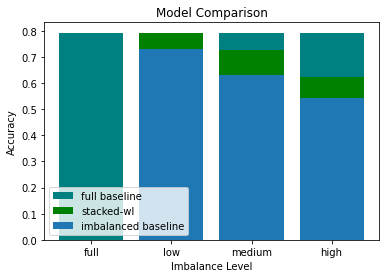

In [11]:
import matplotlib.pyplot as plt

full_baseline = [0.792, 0.792, 0.792, 0.792]
imbalanced_baseline = [0, 0.7296, 0.6304, 0.5446]
stacked = [0, 0.793, 0.725, 0.622]
x_axis = ['full', 'low', 'medium', 'high']

plt.title("Model Comparison")
plt.xlabel("Imbalance Level")
plt.ylabel("Accuracy")
plt.bar(x_axis, full_baseline, color= 'teal')
plt.bar(x_axis, stacked, color='green')
plt.bar(x_axis, imbalanced_baseline)
plt.legend(["full baseline", "stacked-wl", "imbalanced baseline"], loc=3)

## Speaker Notes

In [ ]:
# General Experiment Slide Structure:
# Title Slide introduces motivation/procedure
# Body Slides demonstrate implementation (code snippets, histograms)
# Analysis slide displays results, interpretation of values (metric graphs) 
# Update of Master Experiment Table and some interpretation of the results in global context.
# (Benefits and Drawbacks)

# -----------------------------------------------------------------
# Baseline: 
# Procedure: Performed Architecture Sweep + Hyperparameter Sweep
# Results: Performing hyperparamter sweep on each dataset,
# we establish a set of baseline accuracies.

# Baseline Slides:
# (Baseline: Objective-- Establish model for evaluating efficacy of future modeling techniques)
# (Tooling: timm and gridai snapshots)
# (Code: Show code snapshot of dataset, dataloader) 
# (Arch. Sweep: Show graph of architecture sweep + invocation, provide some bullet analysis)
# (Hp. Sweep: Show graph of hyperparamter sweep + invocation, provide some bullet analysis)
# (Data Augmentation: Show graph of data augmentation + augmented histogram, provide some bullet analysis)
# (Experiment Summary: Show blank experiment table and fill in the baseline column.)

# ||
# \/

# Artificial Balancing: 
# Procedure: Performed Up/Down Sampling to a median threshold. 
# Results: Accuracy increase by 2-5%. 
# Unfortunately modeling approach requires additional memory 
# and runtime costs to produce artifically balanced dataset.
# Can we do better?

# Artifical Balancing Slides:
# (Modeling Technique #1: Artificial Balancing- Explain Procedure and Main Idea- enumate the test distribution)
# (Implementation: Show histogram visuals and algorithm to compute new dataset)
# (Results: Show a graph just to demonstrate some hyperparameter tuning, invocation, and table of accuracies)
# (Experiment Summary: Show blank experiment table and fill in the ab column. Discuss Results.)

# ||
# \/ 

# Weighted Loss: 
# Procedure: Weigh each sample's contribution to total loss 
# by each sample's class frequency in the training dataset.
# Results: Good replacement to artifical balancing, same improvement to accuracy without memory or runtime costs.

# Weighted Loss Slides:
# (Weighted Loss: Procedure explained above, idea is to emulate a balanced dataset 
# by weight minority samples as greater weight as if the nueral network has seen
# more of the minority class samples as it actually has.)
# (Implementation: Show forumlas and code snippets. We are able to implement this 
# by simply computing the dataset histogram and passing a weight vector to 
# the nn.CrossEntropLoss pytorch module.)
# (Results: Show graph sweeping the weighted loss functions against one another, 
# invocation, and a table of results.
# The conclusion is that the choice of weighted loss function does not matter much.)
# (Experiment Summary: Show blank experiment table and fill in the ab column. Discuss Results.)

# ||
# \/ 

# Ensemble Training - Bagging:
# Procedure: Train multiple learners on balanced subdatasets and combine predicitions together. 
# Results: Unfortunately, improvement is not high. While the learners train on 
# relatively balanced datasets, the side effect is that each dataset is 3-4x smaller. 
# Therefore, each learner can only be so accurate with an average accuracy of __%. 
# However, the ensamble does manage a minor increase in performance, which shows promise
# for future ensemble techniques.

# Ensemble Training - Bagging Slides:
# (Ensemble Training - Bagging: Up to now, have used single model for prediction.
# Idea of bagging is to leverage multiple predictors to create a more robust model.
# The data science version of teamwork. 
# The idea is each model will classify an image based on a different set of features
# such that if one model overfits or guesses incorrectly, another model in the ensemble
# may provide the correct answer.)
# (Implementation: Show the histogram visuals, some code snippets. Code shows nice
# order of execution of algorithm steps.) 
# (Results: Graph demonstrating validation accuracy of each learner and table of results,
# learner accuracy.)
# (Experiment Summary: Fill in a column. Discuss the results.)

# ||
# \/ 

# Ensemble Training - Stacking:
# Procedure: Train multiple architectures in parallel.
# Results: Great success, stronger performance than bagging, which makes 
# sense because we are training on more data with more diverse feature extractors.
# Paired with weighted loss yields very significant performance increase.

# Ensemble Training - Stacking Slides: 
# (Ensemble Training - Stacking: Bagging is weak because we use less data and 
# only difference between learners is the training subset-- all other initalization is the same.
# Stacking solves both problems. Idea is to train multiple architectures on all of the training data.)
# (Implementation: Very Simple Sweep, Code snippet)
# (Results: Show training graph as before and table of results + average learner accuracy.)
# (Experiment Summary: Fill in a column. Discuss the results. All that is left is to turn on 
# our individual model optimization of weighted loss.)
# (Results: Show training graph, table of results, learner accuracy. Each learner 
# performs much higher which results in higher overall performance.)
# (Experiment Summary: Fill in last column, highest accuracy earns a bright green box)

# Concluding Slide -- Best Results slide with table, graph, and parameter table.
# From our experiments, we conclude that stacking with weighted loss 
# is the most effective way to improve performance, with _% accuracy improvement across the board.
# It is also economic, beating a ResNet50 baseline in both accuracy number of parameters.

# Lastly, it is very easy to implement! Among all the experiments conducted, 
# stacking took very little effort for amazing performance. 
# And that's it, thanks for listening to my presentation! 